# Geospatial data processing

Today we're going to look at pulling climate statistics out for suburbs from a shapefile. First let's look at the libraries we're going to use

In [2]:
import geopandas
import shapely
import pandas
import numpy 
import rasterio
import affine

We're using `geopandas` to manage the vector data, and `rasterio` to manage the raster data. You can find the documentation for these libraries here:

- [`geopandas` documentation](http://geopandas.org) - uses `shapely` and `pandas` under the hood to manage geometries and tabular attributes respectively.
- [`rasterio` documentation](https://rasterio.readthedocs.io/en/latest/) - uses `numpy` and `affine` under the hood to manage arrays and transformations respectively.

Feel free to have a browse around and see what else these libraries can do for you. There's also a specialized StackExchange (like a subreddit for StackOverflow) on geospatial stuff here: https://gis.stackexchange.com which typically has a higher signal-to-noise ratio if you get stuck.

### Downloading and parsing BoM climate data

I've downloaded the BoM data for Australia from here: http://www.bom.gov.au/jsp/ncc/climate_averages/temperature/index.jsp?maptype=3&period=aut#maps

BoM, in it's own wisdom, uses a Grid text file which has no useful geospatial aspects so we need a seperate function to put it into a useful format. Feel free to dumpster dive if you want to see how to generate your own geotiffs from numpy arrays otherwise just ignore this function and treat it as a black-box conversion service.

In [14]:
def grid_to_geotiff(filename, return_data=False):
    """ Load data from a Bureau of Meterology 'grid' file and dump out to geotiff
        Output is written to geotiff
        Parameters:
            filename - the file name of the BoM grid file to convert
            return_data - if true, then a Numpy array with the imported
                data is returned when conversion is successful.
    """
    # First six lines are metadata
    # Note: gonna assume the origin is WGS84
    with open(filename) as fhandle:
        meta = {}
        for line in fhandle:
            key, value = line.split()
            key = key.lower()
            meta[key] = value
            if len(meta) == 6:
                break

    # Handle sloppy labelling from BoM
    for idx in ('x', 'y'):
        if meta.get(idx + 'llcorner') is not None:
            meta[idx + 'llcenter'] = meta[idx + 'llcorner']

    # Convert metadata to right format
    type_mapping = {'ncols': int, 'nrows': int,
                    'xllcenter': float, 'yllcenter': float,
                    'cellsize': float, 'nodata_value': float}
    for key, typef in type_mapping.items():
        meta[key] = typef(meta[key])

    # Next lines are info - swap out nodata with nans
    # Last lines are also metadata 'header' but we don't care about that
    data = numpy.genfromtxt(filename, dtype=numpy.float64,
                            skip_header=6, skip_footer=18)

    # Check whether we have masked values to deal with
    has_mask = (meta.get('nodata_value') is not None)
    if has_mask:
        has_mask = True
        nodata_mask = (data - meta['nodata_value']) ** 2 < 1e-6

    ## MAKE GEOTIFF
    # Generate the transform for the grid
    aff = affine.Affine.translation(
        meta['xllcenter'] - meta['cellsize'] * 0.5,
        meta['yllcenter'] + (meta['nrows'] - 0.5) * meta['cellsize']
    ) * affine.Affine.scale(meta['cellsize'], -meta['cellsize'])

    # Make metadata for geotiff
    geotiff_meta = {
        'transform': aff,
        'width': meta['ncols'],
        'height': meta['nrows'],
        'nodata': meta['nodata_value'],
        'tiled': 'no',
        'crs': {'init': 'epsg:4326'},  # assuming WGS84
        'driver': 'GTiff',
        'dtype': 'float64',
        'blockxsize': 128,
        'blockysize': 128,
        'count': 1
    }

    # Write out to file
    with rasterio.open(filename + '.geotiff', 'w', **geotiff_meta) as sink:
        sink.write_band(1, data)
        if has_mask:
            sink.write_mask(nodata_mask.astype(bool))

    # If we're returning the data, convert data mask to numpy.nan
    if return_data:
        if has_mask:
            data[nodata_mask] = numpy.nan
        return data
    else:
        return filename + '.geotiff'

Now lets use this importer to read the grid file and convert it to a georeferenced GeoTIFF

In [20]:
data = {
    'spring': grid_to_geotiff('../data/minspr.txt', return_data=True),
    'summer': grid_to_geotiff('../data/minsum.txt', return_data=True),
    'autumn': grid_to_geotiff('../data/minaut.txt', return_data=True),
    'winter': grid_to_geotiff('../data/minwin.txt', return_data=True)
}

We can show a quick-and-dirty plot of Australia's minimum temperatures for each season

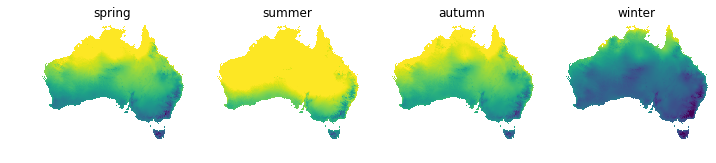

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set the min and maximum so everything uses the same scale
min_temp = -1
max_temp = 20

# Generate the plots for each season
fig, axes = plt.subplots(1, 4)
for (title, temps), ax in zip(data.items(), axes):
    ax.imshow(temps, vmin=min_temp, vmax=max_temp)
    ax.set_title(title)
    ax.set_axis_off()
fig.set_size_inches(12, 4)

### Getting a suburbs shapefile for Perth

We're going to use the suburbs shapefile to extract portions of these temperature maps for Perth. The shapefile is given in the `../data` folder. You can use `geopandas` to read the shapefile just like you'd use `pandas` to read a normal CSV.